## Sistem preporuka polovnih automobila zasnovan na Two-Tower arhitekturi

Cilj ovog projekta je izgradnja sistema za preporuku polovnih automobila koji uci zajednicki embedding prostor za korisnike i vozila koristeci Two-Tower neuronsku arhitekturu. Model povezuje sinteticke korisnicke preferencije i karakteristike automobila kako bi identifikovao najrelevantnije preporuke na osnovu njihove slicnosti.


In [132]:
import re
import numpy as np
import pandas as pd

np.random.seed(42)

def extract_float(series: pd.Series) -> pd.Series:
    """
    Izvlaci prvi decimalni broj iz stringa (npr. '23.4 kmpl', '1248 CC')
    Ako nema broja, vraca NaN
    """
    s = series.astype(str)
    return pd.to_numeric(s.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")

def parse_torque_to_nm(torque_series: pd.Series) -> pd.Series:
    """
     Izvlaci vrednost obrtnog momenta, ako je u kgm/kg-m, konvertuje u Nm
    """
    raw = torque_series.astype(str)
    val = pd.to_numeric(raw.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
    is_kgm = raw.str.contains(r"kgm|kg-m", case=False, na=False)
    val_nm = val.copy()
    val_nm.loc[is_kgm] = val_nm.loc[is_kgm] * 9.80665
    return val_nm

def extract_brand(name_series: pd.Series) -> pd.Series:
    """
    Brend je prva rec u nazivu automobila
    """
    s = name_series.astype(str).str.strip()
    return s.str.split().str[0].fillna("Unknown")


df = pd.read_csv("./data/car-details-v4.csv", low_memory=False)
df.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.0 kmpl,1120 CC,70 bhp,160Nm@ 1500-2750rpm,5.0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32 kmpl,1582 CC,126.32 bhp,259.8Nm@ 1900-2750rpm,5.0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85 kmpl,1197 CC,83.14 bhp,115Nm@ 4000rpm,5.0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.9 kmpl,1197 CC,81.86 bhp,113.75Nm@ 4000rpm,5.0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


### Missing data

In [133]:
df.isna().sum()

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          45
engine           45
max_power        43
torque           45
seats            45
dtype: int64

In [134]:
missing_cnt = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)

display(pd.DataFrame({"missing_count": missing_cnt, "missing_pct": missing_pct}).query("missing_count > 0"))

,missing_count,missing_pct
mileage,45,2.75
engine,45,2.75
torque,45,2.75
seats,45,2.75
max_power,43,2.63


### Prepare data

In [135]:
df = df[
    [
        "name",
        "year",
        "selling_price",
        "km_driven",
        "fuel",
        "seller_type",
        "transmission",
        "owner",
        "mileage",
        "engine",
        "max_power",
        "torque",
        "seats",
    ]
].copy()

df["mileage"] = extract_float(df["mileage"])
df["engine"] = extract_float(df["engine"])
df["max_power"] = extract_float(df["max_power"])
df["torque_nm"] = parse_torque_to_nm(df["torque"])
df = df.drop(columns=["torque"])
df["seats"] = pd.to_numeric(df["seats"], errors="coerce")

### Feature engineering

In [136]:
name = df["name"].astype(str)

df["body_coupe"] = name.str.contains(
    r"Coupe|Sports|Roadster|Convertible|Cabrio|Cabriolet|TT|Z4|S2000|Mustang|GT\b",
    case=False,
    na=False,
).astype(int)

df["body_sedan"] = name.str.contains(
    r"\bSedan\b|Dzire|City|Verna|Civic|Corolla|Passat|Octavia|Jetta|C-Class|S-Class",
    case=False,
    na=False,
).astype(int)

df["body_suv"] = name.str.contains(
    r"Scorpio|Bolero|Fortuner|Safari|Innova|Jeep|XUV|Endeavour|Creta|Harrier|Hector|Duster",
    case=False,
    na=False,
).astype(int)

df["brand"] = extract_brand(df["name"])

premium_brands = {
    "Mercedes",
    "BMW",
    "Audi",
    "Lexus",
    "Jaguar",
    "Volvo",
    "Porsche",
    "Land",
    "Range",
}

df["is_premium_brand"] = df["brand"].isin(premium_brands).astype(int)
df.loc[name.str.contains(r"Land Rover", case=False, na=False), "is_premium_brand"] = 1
df.loc[name.str.contains(r"Range Rover", case=False, na=False), "is_premium_brand"] = 1

### Clean categorical columns

In [137]:
cat_cols = ["fuel", "seller_type", "transmission", "owner"]
for c in cat_cols:
    df[c] = (
        df[c]
        .astype(str)
        .replace({"nan": np.nan, "None": np.nan})
        .fillna("Unknown")
        .str.strip()
    )

for c in ["year", "selling_price", "km_driven"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["name", "year", "selling_price", "km_driven"]).copy()

num_cols = ["mileage", "engine", "max_power", "torque_nm", "seats"]

for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

df = df[df["year"].between(1980, 2030)]
df = df[df["selling_price"] > 0]
df = df[df["km_driven"] >= 0]
df = df[df["seats"].between(2, 10)]

df.reset_index(drop=True, inplace=True)
df.isna().sum()

name                0
year                0
selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage             0
engine              0
max_power           0
seats               0
torque_nm           0
body_coupe          0
body_sedan          0
body_suv            0
brand               0
is_premium_brand    0
dtype: int64

In [138]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_nm,body_coupe,body_sedan,body_suv,brand,is_premium_brand
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.00,1120.0,70.00,5.0,160.00,0,0,0,Hyundai,0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32,1582.0,126.32,5.0,259.80,0,1,0,Hyundai,0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85,1197.0,83.14,5.0,115.00,0,1,0,Maruti,0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.90,1197.0,81.86,5.0,113.75,0,0,0,Hyundai,0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.00,5.0,190.00,0,1,0,Maruti,0


### Outlier handling

In [139]:
clip_cols = ["selling_price", "km_driven", "engine", "max_power", "torque_nm"]

for c in clip_cols:
    low, high = df[c].quantile([0.01, 0.99])
    df[c] = df[c].clip(lower=low, upper=high)

df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,torque_nm,body_coupe,body_sedan,body_suv,is_premium_brand
count,1636.000000,1.636000e+03,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000
mean,2014.342298,1.714498e+06,64065.471363,18.091589,1667.842910,134.532256,5.221271,226.476544,0.035452,0.092910,0.124083,0.072738
std,4.453794,3.925769e+06,44116.193273,5.196142,922.386098,135.037952,1.085320,173.973347,0.184977,0.290394,0.329777,0.259786
min,1995.000000,5.500000e+04,4000.000000,0.000000,624.000000,37.000000,2.000000,59.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,2.600000e+05,29000.000000,15.370000,1197.000000,70.000000,5.000000,113.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,4.970000e+05,58788.500000,18.600000,1396.000000,88.200000,5.000000,190.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,8.204992e+05,90000.000000,21.660000,1991.000000,121.300000,5.000000,259.800000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,2.450000e+07,217950.950000,32.520000,5998.000000,689.850000,10.000000,900.000000,1.000000,1.000000,1.000000,1.000000


Nakon percentilnog ograničavanja (1–99%), uklonjen je uticaj ekstremnih vrednosti, cime je obezbeđen stabilniji trening i manji rizik od overfitting-a.

### EDA (Exploratory Data Analysis)

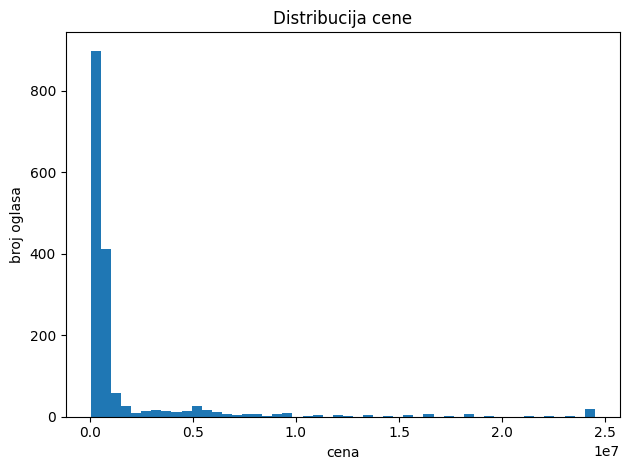

In [140]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["selling_price"].dropna(), bins=50)
plt.title("Distribucija cene")
plt.xlabel("cena")
plt.ylabel("broj oglasa")
plt.tight_layout()
plt.show()

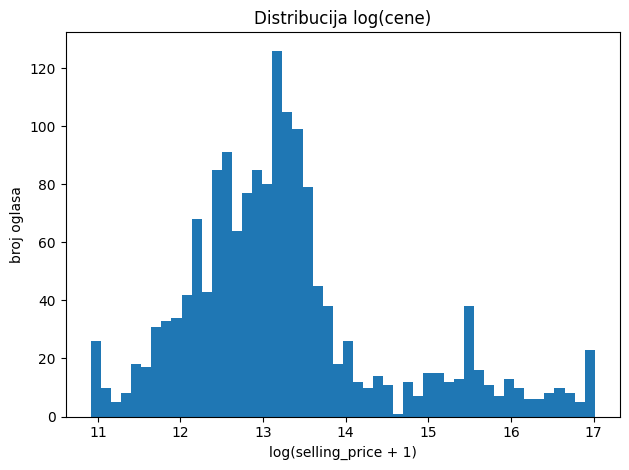

In [141]:
plt.figure()
plt.hist(np.log1p(df["selling_price"]), bins=50)
plt.title("Distribucija log(cene)")
plt.xlabel("log(selling_price + 1)")
plt.ylabel("broj oglasa")
plt.tight_layout()
plt.show()

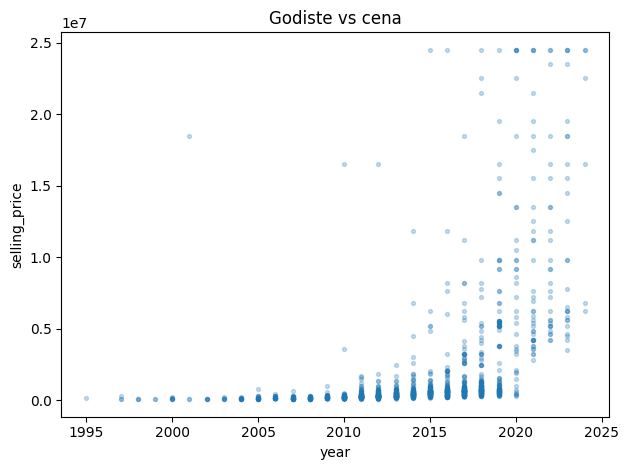

In [142]:
plt.figure()
plt.scatter(df["year"], df["selling_price"], s=8, alpha=0.25)
plt.title("Godiste vs cena")
plt.xlabel("year")
plt.ylabel("selling_price")
plt.tight_layout()
plt.show()

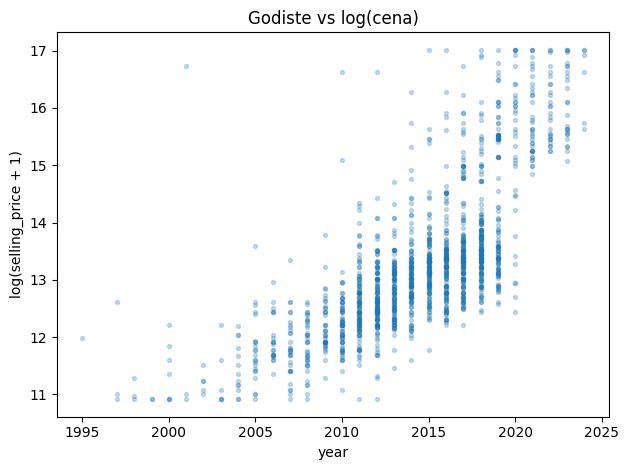

In [143]:
plt.figure()
plt.scatter(df["year"], np.log1p(df["selling_price"]), s=8, alpha=0.25)
plt.title("Godiste vs log(cena)")
plt.xlabel("year")
plt.ylabel("log(selling_price + 1)")
plt.tight_layout()
plt.show()

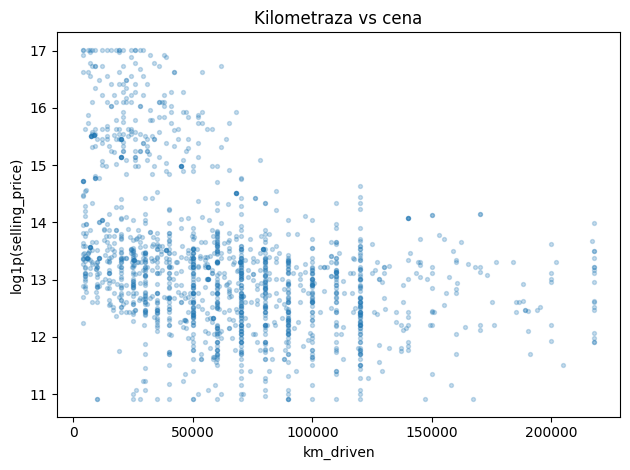

In [144]:
plt.figure()
plt.scatter(df["km_driven"], np.log1p(df["selling_price"]), s=8, alpha=0.25)
plt.title("Kilometraza vs cena")
plt.xlabel("km_driven")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

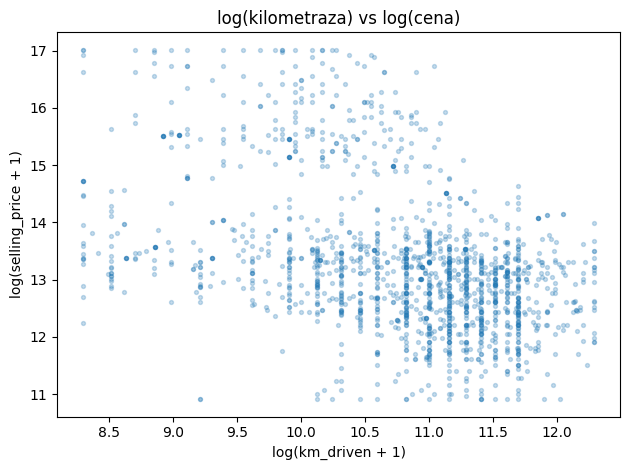

In [145]:
plt.figure()
plt.scatter(np.log1p(df["km_driven"]), np.log1p(df["selling_price"]), s=8, alpha=0.25)
plt.title("log(kilometraza) vs log(cena)")
plt.xlabel("log(km_driven + 1)")
plt.ylabel("log(selling_price + 1)")
plt.tight_layout()
plt.show()

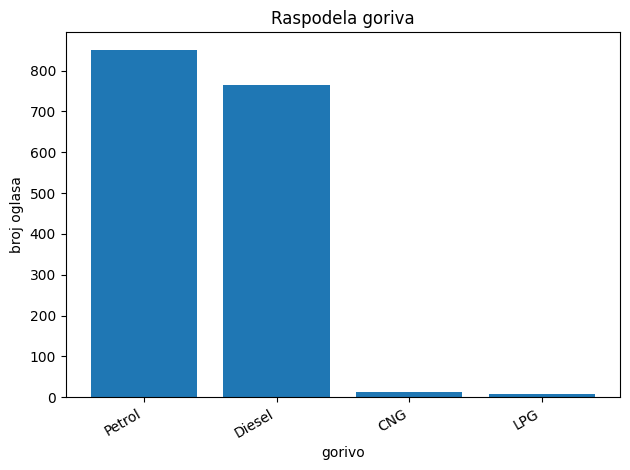

In [146]:
fuel_counts = df["fuel"].value_counts(dropna=False)
plt.figure()
plt.bar(fuel_counts.index.astype(str), fuel_counts.values)
plt.title("Raspodela goriva")
plt.xlabel("gorivo")
plt.ylabel("broj oglasa")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

1. Metan (CNG)
2. Dizel
3. Plin (LPG)
4. Benzin

Vidimo da vecina oglasa koristi benzin ili dizel, dok su alternativna goriva (CNG, LPG) slabo zastupljena, sto moze uticati na ucenje embeddinga za ovu kategoriju.

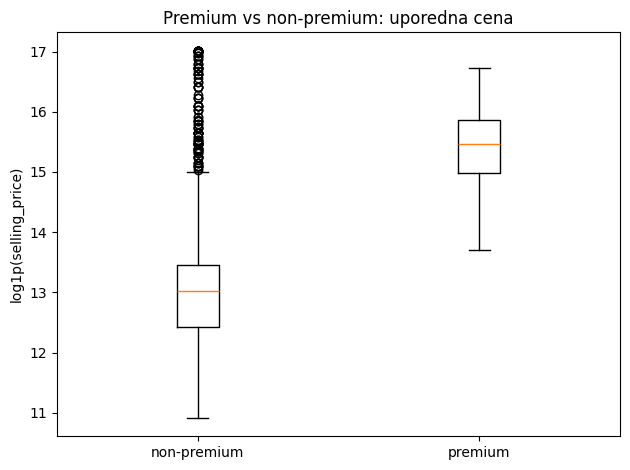

In [147]:
premium = np.log1p(df.loc[df["is_premium_brand"] == 1, "selling_price"])
non_premium = np.log1p(df.loc[df["is_premium_brand"] == 0, "selling_price"])

plt.figure()
plt.boxplot(
    [non_premium.dropna(), premium.dropna()],
    tick_labels=["non-premium", "premium"]
)
plt.title("Premium vs non-premium: uporedna cena")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

### Preprocesiranje/Enkodiranje

In [148]:
from sklearn.preprocessing import MinMaxScaler

CAR_NUM_COLS = [
    "year",
    "km_driven",
    "mileage",
    "engine",
    "max_power",
    "torque_nm",
    "seats",
]

CAR_CAT_COLS = ["fuel", "seller_type", "transmission", "owner"]
CAR_BIN_COLS = ["body_suv", "body_sedan", "body_coupe", "is_premium_brand"]

for c in CAR_CAT_COLS:
    df[c] = (
        df[c]
        .astype(str)
        .replace({"nan": np.nan, "None": np.nan})
        .fillna("Unknown")
        .str.strip()
    )

car_scaler = MinMaxScaler()
df[CAR_NUM_COLS] = car_scaler.fit_transform(df[CAR_NUM_COLS])

car_cat_maps = {}
car_cat_sizes = {}

for c in CAR_CAT_COLS:
    cats = sorted(df[c].unique())
    if "Unknown" not in cats:
        cats = ["Unknown"] + cats

    car_cat_maps[c] = {k: i for i, k in enumerate(cats)}
    car_cat_sizes[c] = len(cats)

    df[c] = df[c].map(car_cat_maps[c]).fillna(car_cat_maps[c]["Unknown"]).astype(int)

num_fuel = car_cat_sizes["fuel"]
num_seller = car_cat_sizes["seller_type"]
num_trans = car_cat_sizes["transmission"]
num_owner = car_cat_sizes["owner"]

def get_car_code(col: str, name: str) -> int:
    return car_cat_maps[col].get(name, car_cat_maps[col]["Unknown"])

petrol_code = get_car_code("fuel", "Petrol")
diesel_code = get_car_code("fuel", "Diesel")

manual_code = get_car_code("transmission", "Manual")
auto_code = get_car_code("transmission", "Automatic")

first_owner_code = get_car_code("owner", "First Owner")
second_owner_code = get_car_code("owner", "Second Owner")

df_items = df[CAR_NUM_COLS + CAR_CAT_COLS + CAR_BIN_COLS].copy()
df_items.head()

,year,km_driven,mileage,engine,max_power,torque_nm,seats,fuel,seller_type,transmission,owner,body_suv,body_sedan,body_coupe,is_premium_brand
0,0.620690,0.532832,0.738007,0.092296,0.050548,0.120095,0.375,2,2,2,1,0,0,0,0
1,0.620690,0.303808,0.686347,0.178266,0.136816,0.238763,0.375,2,2,2,4,0,1,0,0
2,0.689655,0.098153,0.641144,0.106624,0.070675,0.066587,0.375,4,2,2,3,0,1,0,0
3,0.689655,0.448701,0.519680,0.106624,0.068714,0.065101,0.375,4,2,1,1,0,0,0,0
4,0.689655,0.495441,0.817651,0.116115,0.056675,0.155767,0.375,2,2,2,1,0,1,0,0


In [149]:
df_items.isna().sum()

year                0
km_driven           0
mileage             0
engine              0
max_power           0
torque_nm           0
seats               0
fuel                0
seller_type         0
transmission        0
owner               0
body_suv            0
body_sedan          0
body_coupe          0
is_premium_brand    0
dtype: int64

### Users data

In [150]:
USER_CSV_PATH = "./data/user-details.csv"
users_df = pd.read_csv(USER_CSV_PATH)

REQUIRED_USER_COLS = [
    "age",
    "has_family",
    "annual_km",
    "primary_use",
    "drive_style",
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
    "transmission_pref",
    "fuel_pref",
]

missing = [c for c in REQUIRED_USER_COLS if c not in users_df.columns]
if missing:
    raise ValueError(f"Missing columns in user CSV: {missing}")

users_df.head()

,age,has_family,annual_km,primary_use,drive_style,budget_level,comfort_priority,performance_priority,eco_priority,space_need,reliability_priority,offroad_need,transmission_pref,fuel_pref
0,56,1,16284,daily,calm,0.82,0.79,0.31,0.66,0.58,0.53,0.25,Manual,Any
1,59,0,7747,daily,normal,0.12,0.44,0.63,1.00,0.55,0.68,0.10,Any,Any
2,21,1,13433,daily,calm,0.35,0.41,0.73,0.97,0.61,0.74,0.00,Automatic,Any
3,59,1,14692,weekend,normal,0.42,0.78,0.50,0.47,0.62,0.28,0.06,Automatic,Any
4,62,0,7568,mixed,calm,0.71,0.83,0.20,0.41,0.53,0.89,0.10,Any,Any


In [151]:
for c in [
    "age",
    "has_family",
    "annual_km",
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]:
    users_df[c] = pd.to_numeric(users_df[c], errors="coerce")

for c in ["primary_use", "drive_style", "transmission_pref", "fuel_pref"]:
    users_df[c] = users_df[c].astype(str).str.strip()

In [152]:
users_df = users_df.dropna(subset=["age", "has_family", "annual_km"]).copy()

users_df["age"] = users_df["age"].clip(18, 80).astype(int)
users_df["has_family"] = users_df["has_family"].clip(0, 1).astype(int)
users_df["annual_km"] = users_df["annual_km"].clip(1000, 100000).astype(int)

for c in [
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]:
    users_df[c] = users_df[c].clip(0.0, 1.0)

users_df.reset_index(drop=True, inplace=True)
users_df.head()

,age,has_family,annual_km,primary_use,drive_style,budget_level,comfort_priority,performance_priority,eco_priority,space_need,reliability_priority,offroad_need,transmission_pref,fuel_pref
0,56,1,16284,daily,calm,0.82,0.79,0.31,0.66,0.58,0.53,0.25,Manual,Any
1,59,0,7747,daily,normal,0.12,0.44,0.63,1.00,0.55,0.68,0.10,Any,Any
2,21,1,13433,daily,calm,0.35,0.41,0.73,0.97,0.61,0.74,0.00,Automatic,Any
3,59,1,14692,weekend,normal,0.42,0.78,0.50,0.47,0.62,0.28,0.06,Automatic,Any
4,62,0,7568,mixed,calm,0.71,0.83,0.20,0.41,0.53,0.89,0.10,Any,Any


In [153]:
USER_NUM_COLS = [
    "age",
    "annual_km",
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]

USER_BIN_COLS = ["has_family"]
USER_CAT_COLS = ["primary_use", "drive_style", "transmission_pref", "fuel_pref"]

users_df[USER_NUM_COLS + USER_BIN_COLS].isna().sum()

age                     0
annual_km               0
budget_level            0
comfort_priority        0
performance_priority    0
eco_priority            0
space_need              0
reliability_priority    0
offroad_need            0
has_family              0
dtype: int64

### Bodovanje automobila po segmentima

In [154]:
def _pick_fuel_code_from_pref(fuel_pref: str, annual_km: int) -> int:
    if fuel_pref == "Petrol":
        return petrol_code
    if fuel_pref == "Diesel":
        return diesel_code
    return diesel_code if annual_km >= 18000 else petrol_code


def _pick_trans_code_from_pref(trans_pref: str, primary_use: str, comfort: float) -> int:
    if trans_pref == "Manual":
        return manual_code
    if trans_pref == "Automatic":
        return auto_code
    if primary_use == "daily" and comfort >= 0.55:
        return auto_code
    return manual_code


def profile_to_car_pref(user_row: pd.Series) -> dict:
    """
    Mapira driver-like user u internu car-preferencu (car feature space).
    Sve numeric vrednosti su u [0,1] da odgovaraju df_items skaliranom sa MinMaxScaler.
    """
    has_family = int(user_row["has_family"])
    annual_km = int(user_row["annual_km"])

    primary_use = str(user_row["primary_use"]).strip()
    drive_style = str(user_row["drive_style"]).strip()

    budget = float(user_row["budget_level"])
    comfort = float(user_row["comfort_priority"])
    perf = float(user_row["performance_priority"])
    eco = float(user_row["eco_priority"])
    space = float(user_row["space_need"])
    rel = float(user_row["reliability_priority"])
    offroad = float(user_row["offroad_need"])

    year = np.clip(0.35 + 0.45 * rel + 0.15 * budget + 0.10 * (primary_use == "daily"), 0.0, 1.0)

    # smanjena tezina budzeta da ne gura Bentley/Rolls svuda
    selling_price = np.clip(0.20 + 0.60 * budget + 0.10 * comfort, 0.0, 1.0)

    km_driven = np.clip(0.55 - 0.25 * rel + 0.20 * (primary_use == "weekend"), 0.0, 1.0)

    mileage = np.clip(0.35 + 0.60 * eco, 0.0, 1.0)
    engine = np.clip(0.20 + 0.70 * perf, 0.0, 1.0)
    max_power = np.clip(0.15 + 0.80 * perf, 0.0, 1.0)
    torque_nm = np.clip(0.20 + 0.75 * perf, 0.0, 1.0)

    seats = np.clip(0.25 + 0.75 * (0.65 * space + 0.35 * has_family), 0.0, 1.0)

    body_suv = 1.0 if (offroad >= 0.45 or (space >= 0.65 and has_family == 1)) else 0.0
    body_coupe = 1.0 if (perf >= 0.70 and has_family == 0 and space <= 0.45 and drive_style == "sporty") else 0.0
    body_sedan = 1.0 if (body_suv == 0.0 and body_coupe == 0.0) else 0.0

    # manje agresivan premium signal
    is_premium_brand = 1.0 if (budget >= 0.80 and comfort >= 0.75) else 0.0

    fuel_code = _pick_fuel_code_from_pref(str(user_row["fuel_pref"]).strip(), annual_km)
    trans_code = _pick_trans_code_from_pref(str(user_row["transmission_pref"]).strip(), primary_use, comfort)

    seller_code = get_car_code("seller_type", "Dealer") if rel >= 0.55 else get_car_code("seller_type", "Individual")
    owner_code = first_owner_code if rel >= 0.55 else second_owner_code

    return {
        "year": float(year),
        "selling_price": float(selling_price),
        "km_driven": float(km_driven),
        "mileage": float(mileage),
        "engine": float(engine),
        "max_power": float(max_power),
        "torque_nm": float(torque_nm),
        "seats": float(seats),
        "fuel": int(fuel_code),
        "seller_type": int(seller_code),
        "transmission": int(trans_code),
        "owner": int(owner_code),
        "body_suv": float(body_suv),
        "body_sedan": float(body_sedan),
        "body_coupe": float(body_coupe),
        "is_premium_brand": float(is_premium_brand),
    }


def score_items_for_user_profile(user_row: pd.Series, cars_df: pd.DataFrame) -> np.ndarray:
    """
    Score svih automobila za jedan driver-like user.
    Vraca score vector (float32).
    """
    pref = profile_to_car_pref(user_row)

    user_num = np.array([pref[c] for c in CAR_NUM_COLS], dtype="float32")
    car_num = cars_df[CAR_NUM_COLS].values.astype("float32")

    diff = np.abs(car_num - user_num)
    base_sim = np.clip(1.0 - diff, 0.0, 1.0)
    score = base_sim.sum(axis=1).astype("float32")

    score += 0.8 * (cars_df["fuel"].values == pref["fuel"]).astype("float32")
    score += 0.6 * (cars_df["transmission"].values == pref["transmission"]).astype("float32")
    score += 0.2 * (cars_df["seller_type"].values == pref["seller_type"]).astype("float32")
    score += 0.2 * (cars_df["owner"].values == pref["owner"]).astype("float32")

    score += 2.0 * (cars_df["body_suv"].values.astype("float32") * pref["body_suv"])
    score += 2.0 * (cars_df["body_coupe"].values.astype("float32") * pref["body_coupe"])
    score += 0.8 * (cars_df["body_sedan"].values.astype("float32") * pref["body_sedan"])

    score += 0.2 * (cars_df["is_premium_brand"].values.astype("float32") * pref["is_premium_brand"])

    return score.astype("float32")


### Generisanje trening parova (pozitivni/negativni)

In [173]:
def generate_training_pairs(users_df, cars_df, n_pos=15, n_neg=15, hard_neg_ratio=0.7):
    # ITEM (cars) tensors
    cars_num = cars_df[CAR_NUM_COLS].values.astype("float32")
    cars_fuel = cars_df["fuel"].values.astype("int32")
    cars_seller = cars_df["seller_type"].values.astype("int32")
    cars_trans = cars_df["transmission"].values.astype("int32")
    cars_owner = cars_df["owner"].values.astype("int32")
    cars_bin = cars_df[CAR_BIN_COLS].values.astype("float32")

    # USER tensors
    u_num_list, u_fuel_list, u_seller_list, u_trans_list, u_owner_list, u_bin_list = [], [], [], [], [], []
    i_num_list, i_fuel_list, i_seller_list, i_trans_list, i_owner_list, i_bin_list = [], [], [], [], [], []
    y_list = []

    n_items = len(cars_df)
    n_hard = int(n_neg * hard_neg_ratio)
    n_rand = n_neg - n_hard

    for _, user in users_df.iterrows():
        scores = score_items_for_user_profile(user, cars_df)
        idx_sorted = np.argsort(scores)

        pos_idx = idx_sorted[-n_pos:]

        hard_pool = (
            idx_sorted[-(n_pos + 200):-n_pos]
            if n_items > (n_pos + 200)
            else idx_sorted[:-n_pos]
        )
        if len(hard_pool) == 0:
            hard_pool = idx_sorted[: max(1, n_items - n_pos)]

        hard_idx = (
            np.random.choice(hard_pool, size=min(n_hard, len(hard_pool)), replace=False)
            if n_hard > 0
            else np.array([], dtype=int)
        )

        rand_pool = np.setdiff1d(np.arange(n_items), pos_idx, assume_unique=False)
        rand_idx = (
            np.random.choice(rand_pool, size=min(n_rand, len(rand_pool)), replace=False)
            if n_rand > 0
            else np.array([], dtype=int)
        )

        neg_idx = np.concatenate([hard_idx, rand_idx])

        pref = profile_to_car_pref(user)

        u_num = np.array([pref[c] for c in CAR_NUM_COLS], dtype="float32")
        u_fuel = int(pref["fuel"])
        u_seller = int(pref["seller_type"])
        u_trans = int(pref["transmission"])
        u_owner = int(pref["owner"])
        u_bin = np.array([pref[c] for c in CAR_BIN_COLS], dtype="float32")

        def add(indices, label: float):
            for idx in indices:
                u_num_list.append(u_num)
                u_fuel_list.append(u_fuel)
                u_seller_list.append(u_seller)
                u_trans_list.append(u_trans)
                u_owner_list.append(u_owner)
                u_bin_list.append(u_bin)

                i_num_list.append(cars_num[idx])
                i_fuel_list.append(int(cars_fuel[idx]))
                i_seller_list.append(int(cars_seller[idx]))
                i_trans_list.append(int(cars_trans[idx]))
                i_owner_list.append(int(cars_owner[idx]))
                i_bin_list.append(cars_bin[idx])

                y_list.append(float(label))

        add(pos_idx, 1.0)
        add(neg_idx, 0.0)

    return (
        np.stack(u_num_list).astype("float32"),
        np.array(u_fuel_list, dtype="int32"),
        np.array(u_seller_list, dtype="int32"),
        np.array(u_trans_list, dtype="int32"),
        np.array(u_owner_list, dtype="int32"),
        np.stack(u_bin_list).astype("float32"),
        np.stack(i_num_list).astype("float32"),
        np.array(i_fuel_list, dtype="int32"),
        np.array(i_seller_list, dtype="int32"),
        np.array(i_trans_list, dtype="int32"),
        np.array(i_owner_list, dtype="int32"),
        np.stack(i_bin_list).astype("float32"),
        np.array(y_list, dtype="float32"),
    )


### User & Item tornjevi

In [174]:
import tensorflow as tf
from tensorflow.keras import layers, Model

embedding_dim = 32
num_numeric = len(CAR_NUM_COLS)
num_bin = len(CAR_BIN_COLS)

def emb_dim(n):
    return int(min(16, max(4, round(np.sqrt(n)))))

fuel_emb_dim = emb_dim(num_fuel)
seller_emb_dim = emb_dim(num_seller)
trans_emb_dim = emb_dim(num_trans)
owner_emb_dim = emb_dim(num_owner)

# USER tower
user_numeric_in = layers.Input(shape=(num_numeric,), name="user_num")
user_bin_in = layers.Input(shape=(num_bin,), name="user_bin")

user_fuel_in = layers.Input(shape=(), dtype="int32", name="user_fuel")
user_seller_in = layers.Input(shape=(), dtype="int32", name="user_seller")
user_trans_in = layers.Input(shape=(), dtype="int32", name="user_trans")
user_owner_in = layers.Input(shape=(), dtype="int32", name="user_owner")

uf_emb = layers.Embedding(num_fuel, fuel_emb_dim)(user_fuel_in)
us_emb = layers.Embedding(num_seller, seller_emb_dim)(user_seller_in)
ut_emb = layers.Embedding(num_trans, trans_emb_dim)(user_trans_in)
uo_emb = layers.Embedding(num_owner, owner_emb_dim)(user_owner_in)

u_concat = layers.Concatenate()([
    user_numeric_in,
    user_bin_in,
    layers.Reshape((fuel_emb_dim,))(uf_emb),
    layers.Reshape((seller_emb_dim,))(us_emb),
    layers.Reshape((trans_emb_dim,))(ut_emb),
    layers.Reshape((owner_emb_dim,))(uo_emb),
])

u_hidden = layers.Dense(128, activation="relu")(u_concat)
u_hidden = layers.Dropout(0.2)(u_hidden)
u_hidden = layers.Dense(64, activation="relu")(u_hidden)
u_vec = layers.Dense(embedding_dim)(u_hidden)
u_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="user_l2")(u_vec)

user_tower = Model(
    inputs=[user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in],
    outputs=u_vec,
    name="user_tower",
)

# ITEM tower (car features)
item_numeric_in = layers.Input(shape=(num_numeric,), name="item_num")
item_bin_in = layers.Input(shape=(num_bin,), name="item_bin")

item_fuel_in = layers.Input(shape=(), dtype="int32", name="item_fuel")
item_seller_in = layers.Input(shape=(), dtype="int32", name="item_seller")
item_trans_in = layers.Input(shape=(), dtype="int32", name="item_trans")
item_owner_in = layers.Input(shape=(), dtype="int32", name="item_owner")

if_emb = layers.Embedding(num_fuel, fuel_emb_dim)(item_fuel_in)
is_emb = layers.Embedding(num_seller, seller_emb_dim)(item_seller_in)
it_emb = layers.Embedding(num_trans, trans_emb_dim)(item_trans_in)
io_emb = layers.Embedding(num_owner, owner_emb_dim)(item_owner_in)

i_concat = layers.Concatenate()([
    item_numeric_in,
    item_bin_in,
    layers.Reshape((fuel_emb_dim,))(if_emb),
    layers.Reshape((seller_emb_dim,))(is_emb),
    layers.Reshape((trans_emb_dim,))(it_emb),
    layers.Reshape((owner_emb_dim,))(io_emb),
])

i_hidden = layers.Dense(128, activation="relu")(i_concat)
i_hidden = layers.Dropout(0.2)(i_hidden)
i_hidden = layers.Dense(64, activation="relu")(i_hidden)
i_vec = layers.Dense(embedding_dim)(i_hidden)
i_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="item_l2")(i_vec)

item_tower = Model(
    inputs=[item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in],
    outputs=i_vec,
    name="item_tower",
)


### Two Tower model

In [175]:
dot_score = layers.Dot(axes=1, name="dot")([u_vec, i_vec])

model = Model(
    inputs=[
        user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in,
        item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in,
    ],
    outputs=dot_score,
    name="two_tower",
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.AUC(from_logits=True, name="auc"),
        tf.keras.metrics.BinaryAccuracy(threshold=0.0, name="acc"),
    ],
)

model.summary()

Model: "two_tower"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_64        │ (None, 4)         │         20 │ user_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_65        │ (None, 4)         │         16 │ user_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_66        │ (None, 4)         │         12 │ user_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_67        │ (None, 4)         │         20 │ user_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_68        │ (None, 4)         │         20 │ item_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_69        │ (None, 4)         │         16 │ item_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_70        │ (None, 4)         │         12 │ item_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_71        │ (None, 4)         │         20 │ item_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_num            │ (None, 7)         │          0 │ -               

 Total params: 27,976 (109.28 KB)

 Trainable params: 27,976 (109.28 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
(
    u_num,
    u_fuel,
    u_seller,
    u_trans,
    u_owner,
    u_bin,
    i_num,
    i_fuel,
    i_seller,
    i_trans,
    i_owner,
    i_bin,
    y,
) = generate_training_pairs(users_df, df_items, n_pos=15, n_neg=15, hard_neg_ratio=0.7)

history = model.fit(
    [
        u_num, u_bin, u_fuel, u_seller, u_trans, u_owner,
        i_num, i_bin, i_fuel, i_seller, i_trans, i_owner,
    ],
    y,
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
)


def build_item_inputs_from_df(cars_df: pd.DataFrame):
    num = cars_df[CAR_NUM_COLS].values.astype("float32")
    bin_ = cars_df[CAR_BIN_COLS].values.astype("float32")
    fuel = cars_df["fuel"].values.astype("int32")
    seller = cars_df["seller_type"].values.astype("int32")
    trans = cars_df["transmission"].values.astype("int32")
    owner = cars_df["owner"].values.astype("int32")
    return num, bin_, fuel, seller, trans, owner

item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all = build_item_inputs_from_df(df_items)

item_embeddings = item_tower.predict(
    [item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all],
    verbose=0,
)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.7092 - auc: 0.7797 - loss: 0.5871 - val_acc: 0.7289 - val_auc: 0.8339 - val_loss: 0.5630
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7418 - auc: 0.8269 - loss: 0.5553 - val_acc: 0.7694 - val_auc: 0.8555 - val_loss: 0.5341
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7733 - auc: 0.8606 - loss: 0.5297 - val_acc: 0.7894 - val_auc: 0.8715 - val_loss: 0.5174
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7964 - auc: 0.8756 - loss: 0.5174 - val_acc: 0.8122 - val_auc: 0.8778 - val_loss: 0.5117
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8099 - auc: 0.8876 - loss: 0.5051 - val_acc: 0.8061 - val_auc: 0.8987 - val_loss: 0.4953
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8186 - auc: 0.8951 - loss: 0.4974 - val_acc: 0.8011 - val_auc: 0.8957 - val_loss: 0.4973
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8228 - auc: 0.9008 - loss: 0.4924 - val

Vidimo da loss pada iz epohe u epohu, sto znaci da model uci i da je stabilan.

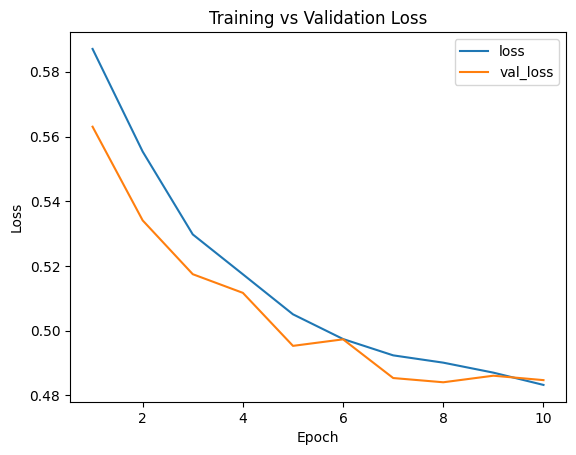

In [177]:
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure()
plt.plot(epochs, history.history["loss"], label="loss")
if "val_loss" in history.history:
    plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

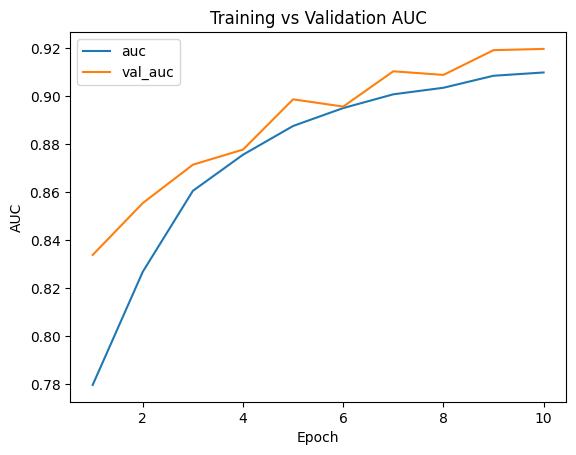

In [178]:
if "auc" in history.history:
    plt.figure()
    plt.plot(epochs, history.history["auc"], label="auc")
    if "val_auc" in history.history:
        plt.plot(epochs, history.history["val_auc"], label="val_auc")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Training vs Validation AUC")
    plt.legend()
    plt.show()

### Skorovi za trening parove

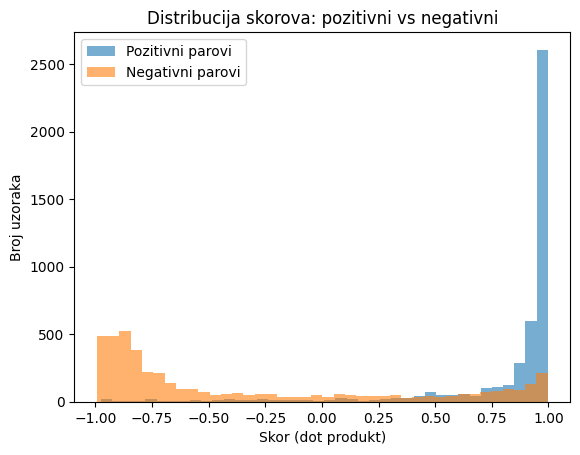

In [179]:
u_emb_train = user_tower.predict(
    [u_num, u_bin, u_fuel, u_seller, u_trans, u_owner],
    verbose=0,
)
i_emb_train = item_tower.predict(
    [i_num, i_bin, i_fuel, i_seller, i_trans, i_owner],
    verbose=0,
)

train_scores = np.sum(u_emb_train * i_emb_train, axis=1)

pos_scores = train_scores[y == 1]
neg_scores = train_scores[y == 0]

plt.figure()
plt.hist(pos_scores, bins=40, alpha=0.6, label="Pozitivni parovi")
plt.hist(neg_scores, bins=40, alpha=0.6, label="Negativni parovi")
plt.xlabel("Skor (dot produkt)")
plt.ylabel("Broj uzoraka")
plt.legend()
plt.title("Distribucija skorova: pozitivni vs negativni")
plt.show()

In [180]:
print("pos median:", np.median(pos_scores), "neg median:", np.median(neg_scores))
print("pos<=0:", (pos_scores <= 0).mean(), "neg>=0:", (neg_scores >= 0).mean())

pos median: 0.96276736 neg median: -0.7112465
pos<=0: 0.04755555555555555 neg>=0: 0.28955555555555557


In [181]:
def recommend_for_user_profile(user_profile: dict, top_n=10):
    """
    user_profile: driver-like dict (age, has_family, annual_km, primary_use, ...).
    Interno se mapira na car-preferencu, pa se radi retrieval nad item_embeddings.
    """
    pref = profile_to_car_pref(pd.Series(user_profile))

    user_num = np.array([[pref[c] for c in CAR_NUM_COLS]], dtype="float32")
    user_bin = np.array([[pref[c] for c in CAR_BIN_COLS]], dtype="float32")

    user_fuel = np.array([pref["fuel"]], dtype="int32")
    user_seller = np.array([pref["seller_type"]], dtype="int32")
    user_trans = np.array([pref["transmission"]], dtype="int32")
    user_owner = np.array([pref["owner"]], dtype="int32")

    u_emb = user_tower.predict(
        [user_num, user_bin, user_fuel, user_seller, user_trans, user_owner],
        verbose=0,
    )

    scores = (u_emb @ item_embeddings.T).ravel()
    sorted_idx = np.argsort(scores)[::-1]

    seen_names = set()
    selected_idx = []
    selected_scores = []

    for idx in sorted_idx:
        name = df.iloc[idx]["name"]
        if name not in seen_names:
            seen_names.add(name)
            selected_idx.append(idx)
            selected_scores.append(float(scores[idx]))
        if len(selected_idx) == top_n:
            break

    out = df.iloc[selected_idx][
        ["name", "year", "selling_price", "km_driven", "fuel", "transmission", "owner"]
    ].copy()
    out["score"] = selected_scores
    return out

### Test

In [182]:
user_sporty_young = {
    "age": 26,
    "has_family": 0,
    "annual_km": 9000,
    "primary_use": "weekend",
    "drive_style": "sporty",
    "budget_level": 0.70,
    "comfort_priority": 0.45,
    "performance_priority": 0.90,
    "eco_priority": 0.30,
    "space_need": 0.25,
    "reliability_priority": 0.50,
    "offroad_need": 0.05,
    "transmission_pref": "Manual",
    "fuel_pref": "Petrol",
}
recommend_for_user_profile(user_sporty_young, top_n=10)

,name,year,selling_price,km_driven,fuel,transmission,owner,score
825,Chevrolet Corvette E-Ray,1.000000,16500000,0.000000,4,1,1,0.960318
411,Chevrolet Corvette ZR1,0.827586,14500000,0.084131,4,1,1,0.957583
1350,Chevrolet Corvette Stingray C7,0.724138,7600000,0.205655,4,2,3,0.953800
1348,Ford Mustang Shelby GT500,0.862069,9800000,0.079457,4,1,1,0.951082
11,Bentley Continental GT Mulliner,0.931034,24500000,0.079457,4,1,1,0.944850
824,Chevrolet Camaro LT1 Coupe,0.896552,4800000,0.116849,4,2,1,0.943737
384,Bentley Continental GT Speed,0.896552,21500000,0.093479,4,1,1,0.943444
1347,Ford Mustang GT Performance,0.862069,5800000,0.102827,4,2,1,0.942819
1579,Maserati Quattroporte Trofeo,0.931034,13500000,0.070110,4,1,1,0.938384
822,Ford Mustang Shelby GT350R,0.827586,9200000,0.112175,4,2,3,0.936337


In [183]:
user_family = {
    "age": 38,
    "has_family": 1,
    "annual_km": 18000,
    "primary_use": "daily",
    "drive_style": "calm",
    "budget_level": 0.50,
    "comfort_priority": 0.75,
    "performance_priority": 0.40,
    "eco_priority": 0.55,
    "space_need": 0.80,
    "reliability_priority": 0.80,
    "offroad_need": 0.30,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_family, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,1800000,0.074783,2,1,1,0.991823
1233,Toyota Fortuner 4x4 AT,0.724138,1750000,0.224350,2,1,1,0.991183
36,Maruti Swift Dzire AMT ZDI,0.724138,650000,0.215003,2,1,3,0.989742
1158,Mahindra Scorpio VLX AT AIRBAG BSIV,0.517241,509999,0.434679,2,1,3,0.989529
1254,Mahindra Scorpio VLS AT 2.2 mHAWK,0.551724,450000,0.425331,2,1,3,0.989421
209,Ford Endeavour 3.0L 4X4 AT,0.551724,975000,0.418171,2,1,3,0.986635
1397,Ford Endeavour 2.2 Titanium AT 4X2,0.724138,2100000,0.378591,2,1,3,0.984908
305,Ford Endeavour 3.2 Titanium AT 4X4,0.724138,2280000,0.542180,2,1,3,0.984838
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,2600000,0.032718,2,1,1,0.984186
446,MG Hector Sharp DCT Dualtone,0.862069,1900000,0.000000,4,1,1,0.983357


In [184]:
user_budget_city = {
    "age": 29,
    "has_family": 0,
    "annual_km": 11000,
    "primary_use": "daily",
    "drive_style": "normal",
    "budget_level": 0.25,
    "comfort_priority": 0.50,
    "performance_priority": 0.35,
    "eco_priority": 0.70,
    "space_need": 0.40,
    "reliability_priority": 0.60,
    "offroad_need": 0.10,
    "transmission_pref": "Manual",
    "fuel_pref": "Any",
}
recommend_for_user_profile(user_budget_city, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
1542,Honda City i VTEC VX Option,0.724138,750000,0.056793,4,2,1,0.997106
1544,Honda City i VTEC V,0.689655,600000,0.112928,4,2,1,0.996333
1199,Honda City i VTEC VX,0.793103,925000,0.116382,4,2,1,0.995198
1533,Honda City i-VTEC V,0.551724,325000,0.168263,4,2,1,0.994687
157,Hyundai Verna Transform VTVT,0.551724,380000,0.355222,4,2,3,0.994180
1540,Honda City i VTEC SV,0.689655,575000,0.026170,4,2,1,0.993086
1205,Maruti Swift Dzire VXI 1.2 BS IV,0.758621,620000,0.401961,4,2,1,0.992675
356,Honda City Corporate Edition,0.586207,540000,0.448701,4,2,3,0.992580
1361,Toyota Corolla Altis 1.8 J,0.482759,340000,0.364570,4,2,3,0.991055
1200,Honda City 1.5 S MT,0.758621,675000,0.212773,4,2,1,0.988132


In [185]:
user_offroad = {
    "age": 34,
    "has_family": 1,
    "annual_km": 20000,
    "primary_use": "mixed",
    "drive_style": "normal",
    "budget_level": 0.55,
    "comfort_priority": 0.65,
    "performance_priority": 0.45,
    "eco_priority": 0.50,
    "space_need": 0.75,
    "reliability_priority": 0.70,
    "offroad_need": 0.80,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_offroad, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,1800000,0.074783,2,1,1,0.991700
1233,Toyota Fortuner 4x4 AT,0.724138,1750000,0.224350,2,1,1,0.991091
36,Maruti Swift Dzire AMT ZDI,0.724138,650000,0.215003,2,1,3,0.989494
1158,Mahindra Scorpio VLX AT AIRBAG BSIV,0.517241,509999,0.434679,2,1,3,0.989003
1254,Mahindra Scorpio VLS AT 2.2 mHAWK,0.551724,450000,0.425331,2,1,3,0.988898
209,Ford Endeavour 3.0L 4X4 AT,0.551724,975000,0.418171,2,1,3,0.986058
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,2600000,0.032718,2,1,1,0.984616
305,Ford Endeavour 3.2 Titanium AT 4X4,0.724138,2280000,0.542180,2,1,3,0.984326
1397,Ford Endeavour 2.2 Titanium AT 4X2,0.724138,2100000,0.378591,2,1,3,0.984198
446,MG Hector Sharp DCT Dualtone,0.862069,1900000,0.000000,4,1,1,0.983922


In [186]:
user_premium = {
    "age": 42,
    "has_family": 0,
    "annual_km": 15000,
    "primary_use": "mixed",
    "drive_style": "normal",
    "budget_level": 0.85,
    "comfort_priority": 0.90,
    "performance_priority": 0.55,
    "eco_priority": 0.45,
    "space_need": 0.50,
    "reliability_priority": 0.75,
    "offroad_need": 0.10,
    "transmission_pref": "Automatic",
    "fuel_pref": "Petrol",
}
recommend_for_user_profile(user_premium, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
1339,Audi RS3 Sedan,0.896552,5900000,0.093479,4,1,1,0.991293
1601,BMW M3 Sedan,0.758621,5800000,0.149567,4,1,1,0.989735
392,BMW M340i Sedan,0.862069,4600000,0.177611,4,1,3,0.987842
814,Audi S3 Sedan,0.896552,4200000,0.126197,4,1,3,0.987795
1343,Mercedes-AMG C63 S Sedan,0.758621,6800000,0.233698,4,1,3,0.987467
592,Audi Q7 3.0 TDI Quattro Premium Plus,0.586207,1850000,0.308482,2,1,1,0.982380
588,Audi Q7 3.0 TDI Quattro,0.655172,3000000,0.285112,2,1,1,0.982039
586,Audi Q5 3.0 TDI Quattro,0.655172,1850000,0.337138,2,1,1,0.976925
1460,Toyota Corolla GR Sport Turbo,0.896552,3800000,0.102827,4,1,1,0.976588
1605,BMW M5 Competition,0.827586,9800000,0.084131,4,1,1,0.975411


In [187]:
user_high_mileage = {
    "age": 45,
    "has_family": 1,
    "annual_km": 32000,
    "primary_use": "daily",
    "drive_style": "calm",
    "budget_level": 0.60,
    "comfort_priority": 0.70,
    "performance_priority": 0.30,
    "eco_priority": 0.75,
    "space_need": 0.65,
    "reliability_priority": 0.85,
    "offroad_need": 0.15,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_high_mileage, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,1800000,0.074783,2,1,1,0.990961
1233,Toyota Fortuner 4x4 AT,0.724138,1750000,0.224350,2,1,1,0.990221
36,Maruti Swift Dzire AMT ZDI,0.724138,650000,0.215003,2,1,3,0.989785
1158,Mahindra Scorpio VLX AT AIRBAG BSIV,0.517241,509999,0.434679,2,1,3,0.988704
1254,Mahindra Scorpio VLS AT 2.2 mHAWK,0.551724,450000,0.425331,2,1,3,0.988574
209,Ford Endeavour 3.0L 4X4 AT,0.551724,975000,0.418171,2,1,3,0.985630
1397,Ford Endeavour 2.2 Titanium AT 4X2,0.724138,2100000,0.378591,2,1,3,0.983865
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,2600000,0.032718,2,1,1,0.983797
305,Ford Endeavour 3.2 Titanium AT 4X4,0.724138,2280000,0.542180,2,1,3,0.983740
446,MG Hector Sharp DCT Dualtone,0.862069,1900000,0.000000,4,1,1,0.983403
